# Proyecto 2 - Colorización de imágenes con GANs

**Nombre:** Xander Gallegos Velica

**Expediente:** 737989

**Fecha de entrega:** 11 de abril de 2024

**Materia:** Aprendizaje Profundo.

**Repositorio de Github:** [xagallegos/GAN-Image-Colorization](https://github.com/xagallegos/GAN-Image-Colorization)

In [2]:
from utils import *

import os
import time
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
from datetime import datetime

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode

from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from tqdm.notebook import tqdm

global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load dataset - Places365

In [3]:
class Places365():
    def __init__(self, dir_path: str, batch_size: int = 64, split: str = None, size_transform=None):
        if split is None:
          self.dir_path = dir_path
        else:
          self.dir_path = os.path.join(dir_path, split)

        self.img_names = os.listdir(self.dir_path)
        self.batch_size = batch_size
        self.size_transform = size_transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir_path, self.img_names[idx])

        bw_img = read_image(img_path, mode=ImageReadMode.GRAY)
        color_img = read_image(img_path, mode=ImageReadMode.RGB)

        if self.size_transform:
            bw_img = self.size_transform(bw_img)
            color_img = self.size_transform(color_img)


        bw_img = bw_img / 255
        color_img = color_img / 255

        return {'bw': bw_img, 'color': color_img}

In [6]:
def make_dataloader(batch_size=32, n_workers=2, pin_memory=True, **kwargs):
    dataset = Places365(**kwargs)
    dataloader = DataLoader(dataset,
                            shuffle=False,
                            batch_size=batch_size,
                            num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [7]:
path = 'val_256'

train_loader = make_dataloader(dir_path=path, split='train_samples')
print(len(train_loader))

685


### Batch example

In [8]:
batch_data = next(iter(train_loader))

bw, color = batch_data['bw'], batch_data['color']
bw.shape, color.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([32, 1, 256, 256]), torch.Size([32, 3, 256, 256]))

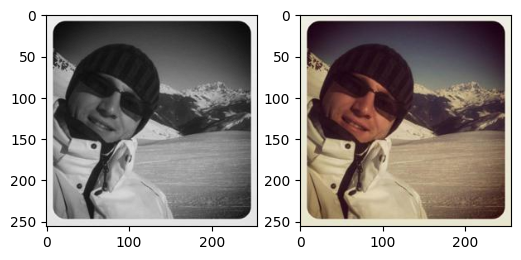

In [9]:
idx = 0

img_bw = bw[idx]
img_c = color[idx]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6,3))

img_bw = transforms.ToPILImage()(img_bw)
img_bw = np.array(img_bw)
ax1.imshow(img_bw, cmap='gray')

img_c = transforms.ToPILImage()(img_c)
img_c = np.array(img_c)
ax2.imshow(img_c)

plt.show()

## GAN

### Generator

In [10]:
def build_res_unet(n_input=1, n_output=3, size=256):
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [11]:
def pretrain_generator(net_G, train_loader, opt, criterion, epochs, checkpoints_dir='', start_epoch=0):
    if start_epoch > 0:
      resume_epoch = start_epoch - 1
      resume(net_G, os.path.join(checkpoints_dir, f"epoch-{resume_epoch}.pth"))


    for e in range(start_epoch, epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_loader):
            bw, color = data['bw'].to(device), data['color'].to(device)
            preds = net_G(bw)
            loss = criterion(preds, color)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), bw.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")
        checkpoint(net_G, os.path.join(checkpoints_dir, f"epoch-{e}.pth"))

In [ ]:
# pre train generator to give it a "head-start" to learning the desired distribution
net_G = build_res_unet(n_input=1, n_output=3, size=256)

opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()

checkpoints = 'generator-checkpoints'
pretrain_generator(net_G, train_loader, opt, criterion, start_epoch=8, epochs=10, checkpoints_dir=checkpoints)

### Discriminator

In [12]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels=3, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_channels, num_filters, norm=False)]

        # making downsampling blocks
        # stride 2 except for last block
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)]

        # last layer doesn't get normalization nor activation
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]

        self.model = nn.Sequential(*model)

    # function to make block of layers
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]

        if norm:
          layers += [nn.BatchNorm2d(nf)]

        if act:
          # 0.2 slope as sugested from Radford A., Metz L., and Chintala S. (2016)
          layers += [nn.LeakyReLU(0.2, True)]

        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### Loss

In [13]:
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.loss = nn.BCEWithLogitsLoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### GAN Model

In [14]:
# learning rate defaulted to 0.0002

class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = device
        self.lambda_L1 = lambda_L1

        # If the generator is not provided, a default untrained one is used
        if net_G is None:
            net_G = build_res_unet(n_input=1, n_output=3, size=256)

        # Initialize generator and discriminator
        self.net_G = net_G.to(device)
        self.net_D = init_model(PatchDiscriminator(input_channels=3, n_down=3, num_filters=64), self.device)

        # Initialize losses
        self.GANcriterion = GANLoss().to(self.device)
        self.L1criterion = nn.L1Loss()

        # Initialize optimizers
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        """"
        Sets requires_grad attribute for all parameters in model
        """
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.gray = data['bw'].to(self.device)
        self.color = data['color'].to(self.device)

    # Generator forward
    def forward(self):
        self.fake_color = self.net_G(self.gray)

    def backward_D(self):
        # Generate fake images and predictions
        fake_image = self.fake_color
        fake_preds = self.net_D(fake_image.detach()) # detach to prevent gradients from flowing back

        # Compute discriminator loss (its ability to guess correctly)
        self.loss_D_fake = self.GANcriterion(fake_preds, False)

        # Get real images and their discriminator predictions
        real_image = self.color
        real_preds = self.net_D(real_image)

        # Compute discriminator loss
        self.loss_D_real = self.GANcriterion(real_preds, True)

        # Combine the losses
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5

        # Backward pass
        self.loss_D.backward()

    # Generator backward
    def backward_G(self):
        # Generate fake images and predictions
        fake_image = self.fake_color
        fake_preds = self.net_D(fake_image)

        # Compute generator loss (its ability to trick the discriminator)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)

        # Compute L1 loss (difference between generated and real image)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.color) * self.lambda_L1

        # Combine the losses
        self.loss_G = self.loss_G_GAN + self.loss_G_L1

        # Backward pass
        self.loss_G.backward()

    def optimize(self):
        # Generator forward pass
        self.forward()

        # Set discriminator to train mode and enable gradient computation
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)

        # Reset discriminator gradient
        self.opt_D.zero_grad()

        # Discriminator backward pass
        self.backward_D()

        # Update discriminator parameters
        self.opt_D.step()

        # Set generator to train mode and disable gradient computation for discriminator
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)

        # Reset generator gradient
        self.opt_G.zero_grad()

        # Generator backward pass
        self.backward_G()

        # Update generator parameters
        self.opt_G.step()

    def save_weights(self, filepath):
        torch.save({
            'net_G_state_dict': self.net_G.state_dict(),
            'net_D_state_dict': self.net_D.state_dict(),
            'opt_G_state_dict': self.opt_G.state_dict(),
            'opt_D_state_dict': self.opt_D.state_dict()
        }, filepath)

    def load_weights(self, filepath):
        checkpoint = torch.load(filepath)
        self.net_G.load_state_dict(checkpoint['net_G_state_dict'])
        self.net_D.load_state_dict(checkpoint['net_D_state_dict'])
        self.opt_G.load_state_dict(checkpoint['opt_G_state_dict'])
        self.opt_D.load_state_dict(checkpoint['opt_D_state_dict'])

In [15]:
def train_model(model, train_dl, epochs, display_every=300, checkpoints_dir='', start_epoch=0):
    if start_epoch > 0:
        resume_epoch = start_epoch - 1
        checkpoint_file = list(filter(lambda x: x.startswith(f'epoch-{resume_epoch}'), os.listdir(checkpoints_dir)))[0]
        checkpoint_file = os.path.join(checkpoints_dir, checkpoint_file)
        model.load_weights(checkpoint_file)

    for e in range(start_epoch, epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) # input batch data
            model.optimize() # train batch
            update_losses(model, loss_meter_dict, count=data['bw'].size(0)) # function updating the log objects
            i += 1

            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses

                data_cpu = {key: value.cpu() for key, value in data.items()}

                visualize(model, data_cpu, save=False) # function displaying the model's outputs

    timestamp = datetime.now().strftime("%d%H%M")
    model.save_weights(os.path.join(checkpoints_dir, f'epoch-{e}_{timestamp}.pth'))


In [ ]:
net_G = build_res_unet(n_input=1, n_output=3, size=256)

# load pre trained generator weights
gen_weights = './models-weights/generator-weights.pth'
resume(net_G, gen_weights)

# initialize main model
model = MainModel(net_G=net_G)

model initialized with norm initialization


In [ ]:
# train main model
gan_checkpoints = 'gan-checkpoints'
train_model(model, train_loader, 5, checkpoints_dir=gan_checkpoints, start_epoch=1)

## Test

In [16]:
# load trained model
model = MainModel()
model.load_weights('./models-weights/gan-weights.pth')

model initialized with norm initialization


In [17]:
# load test dataset
path = 'val_256'

batch_size = 3
test_loader = make_dataloader(dir_path=path, batch_size=batch_size, split='test_samples')
print(len(test_loader))

2397


In [26]:
test_iterator = iter(test_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


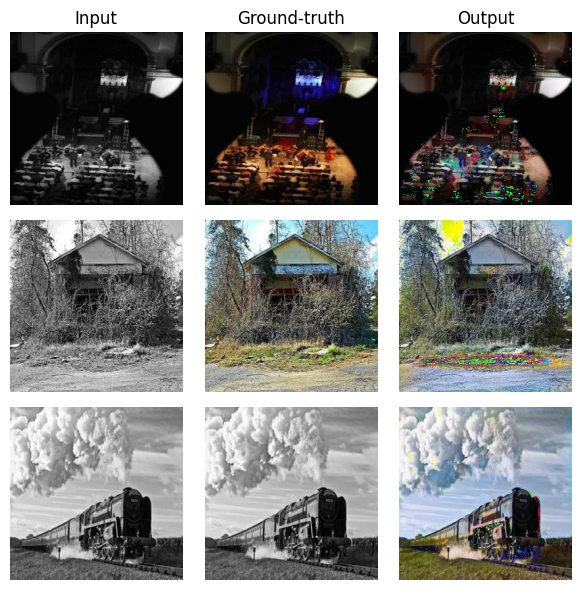

In [79]:
test_data = next(test_iterator)

model.setup_input(test_data)
model.forward()

gray = model.gray
color = model.color
fake_color = model.fake_color

fig, axes = plt.subplots(nrows=batch_size, ncols=3, figsize=(6,6))

for i in range(batch_size):
  axes[i][0].imshow(gray[i][0].cpu(), cmap='gray')

  real = np.array(transforms.ToPILImage()(color[i].cpu()))
  axes[i][1].imshow(real)

  fake = np.array(transforms.ToPILImage()(fake_color[i].cpu())) / 255
  axes[i][2].imshow(fake)

  for ax in axes[i]:
    ax.axis('off')

axes[0, 0].set_title('Input')
axes[0, 1].set_title('Ground-truth')
axes[0, 2].set_title('Output')

plt.tight_layout()
plt.show()